In [3]:
library(tidyverse)
library(tidymodels)
library(repr)
library(rvest)
library(stringr)
library(cowplot)

# Introduction

Tennis is a sport enjoyed by millions of people around the world. The singles format involves two players competing against each other to hit a ball over a net with rackets. Professional tennis players compete in various tournaments throughout the year, accruing prize money based on their performance. In addition to competing for money, many players compete simply for a love of the game, as well as a better spot in the international tennis rankings.

Understanding the potential earnings of top players in the upcoming season is crucial for fans, sponsors and especially the players themselves. This information can help a player determine how much other revenue they will need to acquire, as well as if continuing to play the game is worth it. The question our project aims to answer is: How much will a tennis player earn next season? To answer this question, we will use a dataset called "Player Statistics for Top 500 Players". This dataset contains comprehensive information on the top 500 tennis players, including their personal information, Current and Best rankings and elo rating, prize money earned throughout their career, and personal tennis preferences. It provides valuable data for analyzing historical trends and predicting future bonus earnings.

In order to determine how much a player will earn next season, we must have a good understanding of how good they are now. In tennis, there are 2 main ranking systems: The Pepperstone ATP ranking, and the ATP Elo Rating. While both systems have the same qualifications necessary to be ranked or rated, they measure players' performances in different ways. The Pepperstone ATP ranking awards players points based on their performances in tournaments, with more points awarded for higher placements and more points awarded at larger events. Then players are ranked by the amount of points they have, with the player who has the most points being ranked first (1). On the other hand, the ATP Elo Rating awards players points for individual match wins based on the quality of their opponent. The points are taken from the loser and given to the winner, with the amount of points being determined by the quality of the players (2). While the Pepperstone ranking is often seen as the more official ranking, the elo rating system is gaining popularity, and can give us crucial information that the traditional rankings can't.

# Exploratory Data Analysis

In order to answer our question, we will be approximating the money a player will earn in an upcoming season by the average money per season that player has earned to date. Additionally, based on our question and our research, we determined that the most important data was that which gives us information about how good a player currently is, being their current rank and current elo rating. Given that these two systems provide fundamentally different intent behind rankings, and can provide unique perspective on a player's skill, independent of one another, both systems should be used in our report. Furthermore, we are interested in whether a player's age effects their performance. In general, tennis players retire younger than in other sports, and do so for a variety of reasons including mental strain, aging bodies, and financial instability (3). Being able to predict the earnings of a player based on their age would help inform players whether it is worth it to continue playing the game.

To this end, we read the "Player stats for Top 500 Players" dataset from the internet (4), separated the columns describing current rank and current elo rating so that the rank and the rating were in their own indpendent columns, made all the values numeric, and calculated money per season as prize money divided by seasons active. Finally, we selected the 4 columns relevant to our question and dropped all rows which were missing values for one of the columns. The resulting table can be found below in Figure 1.

In [4]:
tennis <- read_csv('https://drive.google.com/uc?export=download&id=1_MECmUXZuuILYeEOfonSGqodW6qVdhsS')
colnames(tennis) <- make.names(colnames(tennis))

tennis_data <- tennis |>
filter(Active == "Yes") |>
separate(col = Age, into = c("Age", "Birth.Date"), sep = " ") |>
separate(col = Current.Rank, into = c("Current.Rank", "Prev.Rank"), sep = " ") |>
separate(col = Current.Elo.Rank, into = c("Current.Elo.Rank", "Current.Elo.Rating"), sep = " ") |>
mutate(Age = as.numeric(Age),
       Current.Rank = as.numeric(Current.Rank), 
       Current.Elo.Rating = as.numeric(gsub("[^0-9.-]", "", Current.Elo.Rating)),
       Prize.Money = as.numeric(gsub("[^0-9.-]", "", Prize.Money)),
       Money.Per.Season = Prize.Money/Seasons) |>
select(Age, Current.Rank, Current.Elo.Rating, Money.Per.Season) |>
drop_na()

options(repr.matrix.max.rows = 6)
print("Figure 1")
tennis_data

New names:
• `` -> `...1`
Rows: 500 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (25): Age, Country, Plays, Wikipedia, Current Rank, Best Rank, Name, Bac...
dbl (13): ...1, Turned Pro, Seasons, Titles, Best Season, Retired, Masters, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


[1] "Figure 1"


Age,Current.Rank,Current.Elo.Rating,Money.Per.Season
<dbl>,<dbl>,<dbl>,<dbl>
32,178,1764,232969.1
27,183,1826,553815.5
22,31,1983,303431.4
⋮,⋮,⋮,⋮
24,103,1627,103659.25
28,292,1764,149759.14
26,324,1679,16608.88


Next, we split our data into a training and a testing set, so that we could begin performing data analysis, with a proportion of 75% training, and a target variable of Money.Per.Season.

In [5]:
set.seed(16)

tennis_split <- initial_split(tennis_data, prop = 0.75, strata = Money.Per.Season)
tennis_training <- training(tennis_split)
tennis_testing <- testing(tennis_split)

First, we completed exploratory data analysis to determine whether our selected data would indeed be relevant, and give us results. We compiled a table that groups the players by age and reports the means for the other variables (Figure 2). Additionally, we plotted the distribution of the players by age (figure 3). Finally we made scatter plots of the relationship between money per season and each of the other 3 variables to determine if the selected variables would indeed have an effect on our  target variable (Figure 4, 5, 6).

Note: after visualizing the data, it was clear that our set included one extreme outlier that was making it hard to see the desired relationships, so we removed that player from the set for just the visualizations presented here.

[1] "Figure 2"


Age,Mean.Current.Rank,Mean.Current.Elo.Rating,Mean.Money.Per.Season
<dbl>,<dbl>,<dbl>,<dbl>
18,82.00000,1784.000,393235.0
19,93.50000,1815.500,372561.3
20,57.33333,1903.167,487600.0
21,63.00000,1834.500,182385.9
22,56.00000,1887.000,268660.4
23,124.20000,1838.100,395476.2
24,135.37500,1780.875,220232.9
25,139.00000,1788.333,373574.1
26,119.50000,1791.167,255222.7


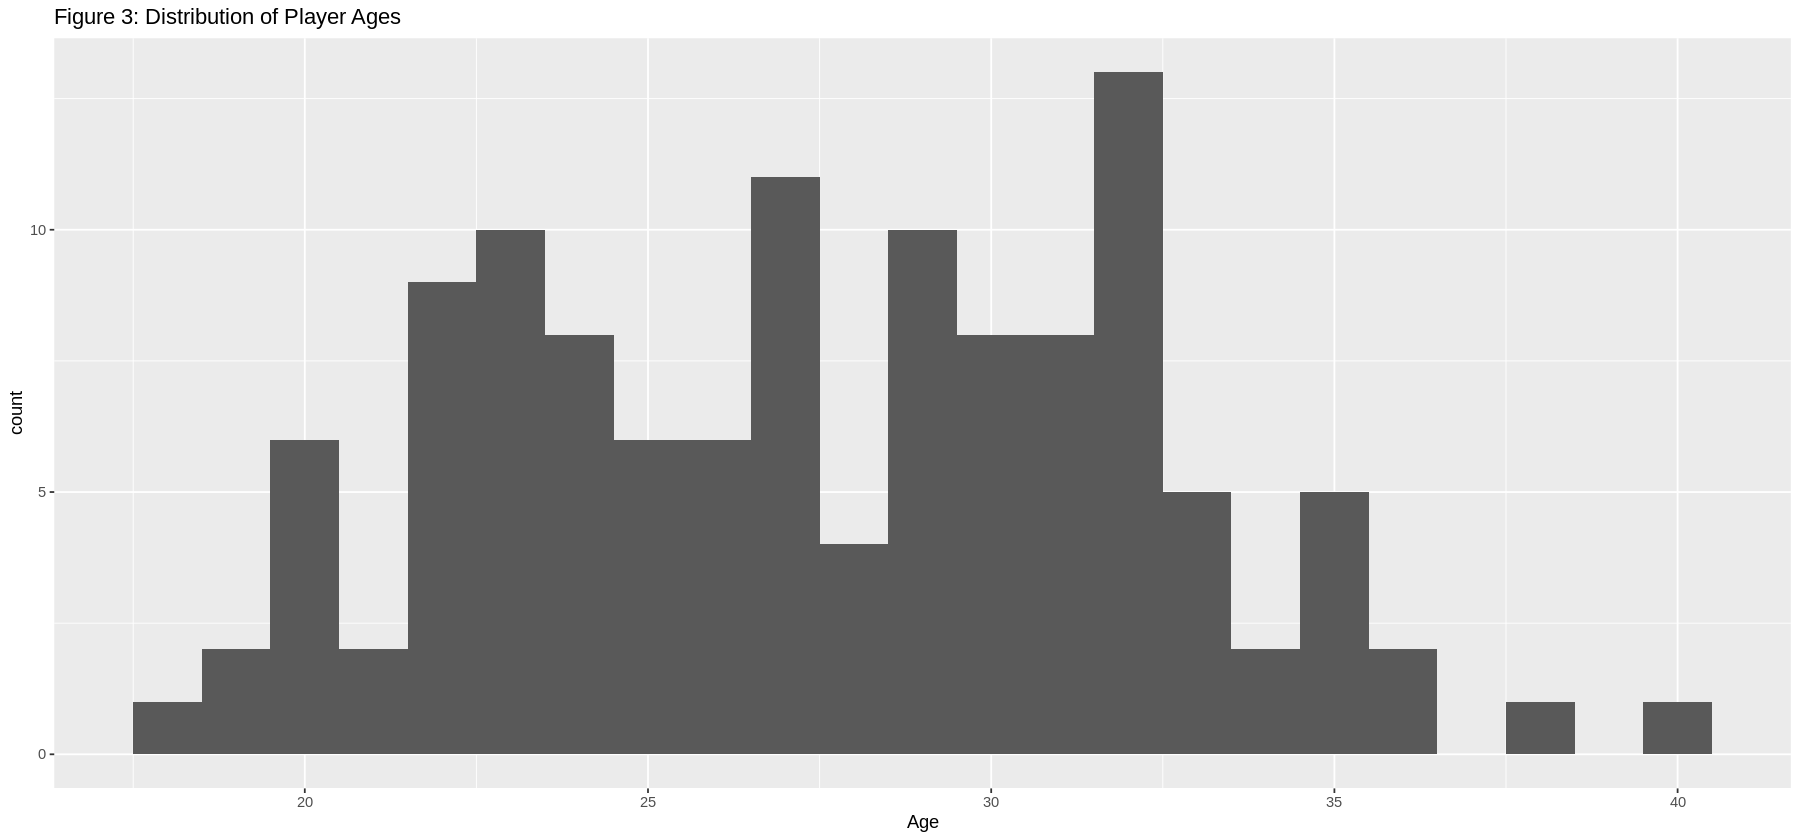

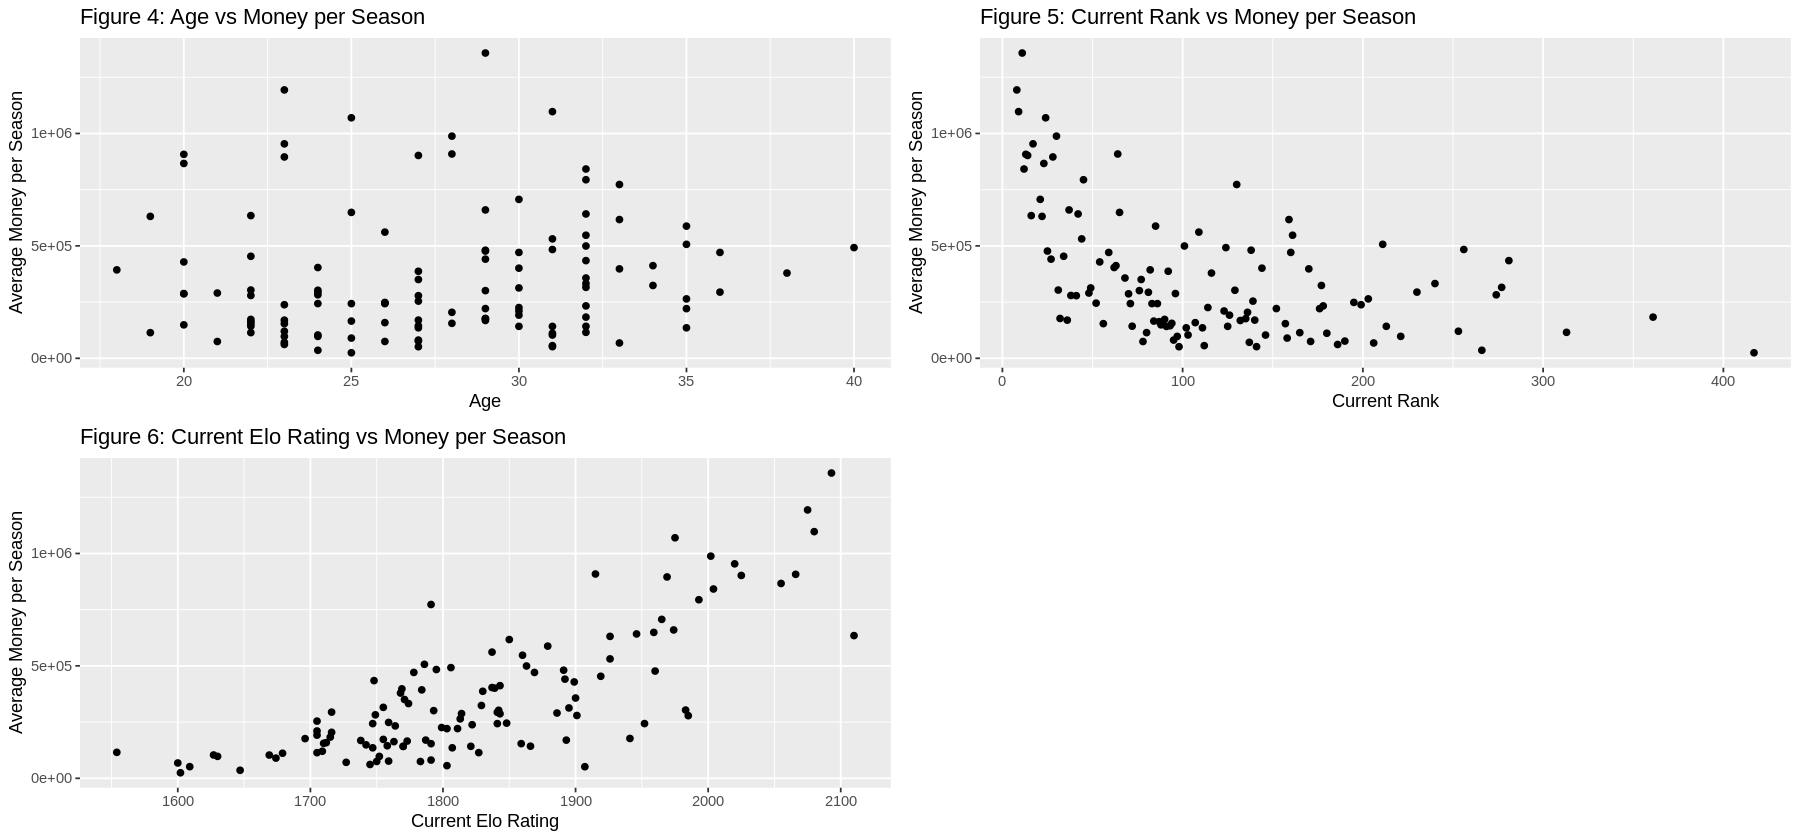

In [6]:
tennis_data_summary <- tennis_training |>
    group_by(Age) |>
    summarize(Mean.Current.Rank = mean(Current.Rank), Mean.Current.Elo.Rating = mean(Current.Elo.Rating),
              Mean.Money.Per.Season = mean(Money.Per.Season))
tennis_age_dist <- tennis_training |>
    ggplot(aes(x = Age)) +
    geom_histogram(binwidth = 1) +
    xlab("Age") +
    ggtitle("Figure 3: Distribution of Player Ages")

tennis_highest_money <- tennis_training |> arrange(desc(Money.Per.Season)) |>
    slice(1) |> pull(Money.Per.Season)
tennis_viz_data <- tennis_training |>
    filter(Money.Per.Season != tennis_highest_money)
tennis_age_plot <- tennis_viz_data |>
    ggplot(aes(x = Age, y = Money.Per.Season)) +
    geom_point() +
    labs(x = "Age", y = "Average Money per Season") +
    ggtitle("Figure 4: Age vs Money per Season")
tennis_rank_plot <- tennis_viz_data |>
    ggplot(aes(x = Current.Rank, y = Money.Per.Season)) +
    geom_point() +
    labs(x = "Current Rank", y = "Average Money per Season") +
    ggtitle("Figure 5: Current Rank vs Money per Season")
tennis_elo_plot <- tennis_viz_data |>
    ggplot(aes(x = Current.Elo.Rating, y = Money.Per.Season)) +
    geom_point() +
    labs(x = "Current Elo Rating", y = "Average Money per Season") +
    ggtitle("Figure 6: Current Elo Rating vs Money per Season")
options(repr.matrix.max.rows = 23, repr.plot.width = 15, repr.plot.height = 7)
print("Figure 2")
tennis_data_summary
tennis_age_dist
plot_grid(tennis_age_plot, tennis_rank_plot, tennis_elo_plot)

From these visualizations, we can see that both current rank and current elo rating have moderately strong relationships with money per season. While the relationship between age and money per season isn't that strong, it can be seen that in general there are more instances of a high money per season earned in the middle of the age range.

# Analysis

We created a recipe with our choosen predictor and standardized them, since the knn algorithm depends on a distance calculation. We then created the specification for a knn regression model and set the neighbors to tune() so we could use cross validation to find the optimal k. 

In [7]:
tennis_recipe <- recipe(Money.Per.Season~Age + Current.Rank + Current.Elo.Rating, data = tennis_training) |>
step_scale(all_predictors()) |>
step_center(all_predictors())

tennis_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
set_engine("kknn") |>
set_mode("regression")

Cross Validation: we created perfomed cross validation with 5 folds on possible values of k from 1 to 30. We estimated that the optimal k would be in this range since more that 30 neighbors would likely result in underfitting. Once cross validation was complete on the training set we pulled the k with the lowest rmse. 

In [ ]:
tennis_vfold <- vfold_cv(tennis_training, v = 5, strata = Money.Per.Season)

tennis_wkflw <- workflow() |>
add_recipe(tennis_recipe) |>
add_model(tennis_spec)

gridvals <- tibble(neighbors = seq(from = 1, to = 30))
tune_results <- tennis_wkflw |>
tune_grid(resamples = tennis_vfold, grid = gridvals) |>
collect_metrics() |>
filter(.metric == "rmse")

best_k <- filter(tune_results, mean == min(mean)) |>
pull(neighbors)

neighbors_plot <- tune_results |>
ggplot(aes(x = neighbors, y = mean)) +
geom_point()

We made a new specification with the k = 3 and fit our workflow to our entire training data set. We then evaluated how well the model performed on the training data, we calculated a RMSPE value of 337994.6.

In [ ]:
best_tennis_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
set_engine("kknn") |>
set_mode("regression")

tennis_fit <- workflow() |>
add_recipe(tennis_recipe) |>
add_model(best_tennis_spec) |>
fit(data = tennis_training)

rmspe_value <- tennis_fit |>
predict(tennis_training) |>
bind_cols(tennis_training) |>
metrics(truth = Money.Per.Season, estimate = .pred) |>
filter(.metric == "rmse")

rmspe_value

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,337994.6


Finally we evaluated the true accuracy by predicting values for our testing set and collecting metrics on the true Money.Per.Season vs the prediction made by our model. Our RMSE value was 342,567.1.  

In [ ]:
tennis_predictions <- tennis_fit |>
predict(tennis_testing) |>
bind_cols(tennis_testing)

tennis_summary <- tennis_predictions |>
metrics(truth = Money.Per.Season, estimate = .pred) |>
filter(.metric == "rmse")
tennis_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,347601.4


Visualization: Since we have 3 predictor variables we created 3 plots to visualized the predictions(the colored lines) vs the training data for each variable. 

age_plot <- ggplot(tennis_training, aes(x = Age, y = Money.Per.Season)) +
  geom_point(alpha = 0.4) +
  geom_line(data = tennis_predictions, 
            mapping = aes(x = Age, y = .pred), 
            color = "red") +
  xlab("Age (years)") +
  ylab("Money made per season(USD)") +
  scale_y_continuous(labels = dollar_format()) +
  ggtitle("Figure 7: Age vs Money Per Season Predictions") + 
  theme(text = element_text(size = 12)) 

current_rank_plot <- ggplot(tennis_training, aes(x = Current.Rank, y = Money.Per.Season)) +
  geom_point(alpha = 0.4) +
  geom_line(data = tennis_predictions, 
            mapping = aes(x = Current.Rank, y = .pred), 
            color = "blue") +
  xlab("Current Rank") +
  ylab("Money made per season(USD)") +
  scale_y_continuous(labels = dollar_format()) +
  ggtitle("Figure 8: Current Rank vs Money Per Season Predictions") + 
  theme(text = element_text(size = 12))

current_elo_plot <- ggplot(tennis_training, aes(x = Current.Elo.Rating, y = Money.Per.Season)) +
  geom_point(alpha = 0.4) +
  geom_line(data = tennis_predictions, 
            mapping = aes(x = Current.Elo.Rating, y = .pred), 
            color = "green") +
  xlab("Current Elo Rating") +
  ylab("Money made per season(USD)") +
  scale_y_continuous(labels = dollar_format()) +
  ggtitle("Figure 9: Current Rank vs Money Per Season Predictions") + 
  theme(text = element_text(size = 12))

Figure 7: For each observation in the training data the players age was plotted against their money made per season. The overlaid red line is a plot of the corresponding predictions made by our model(predicting on the test set) for a player of any give age. It seems generally well fit with some overfitting occuring in the earlier ages, this may be due in part to the shapeless nature of the data. 

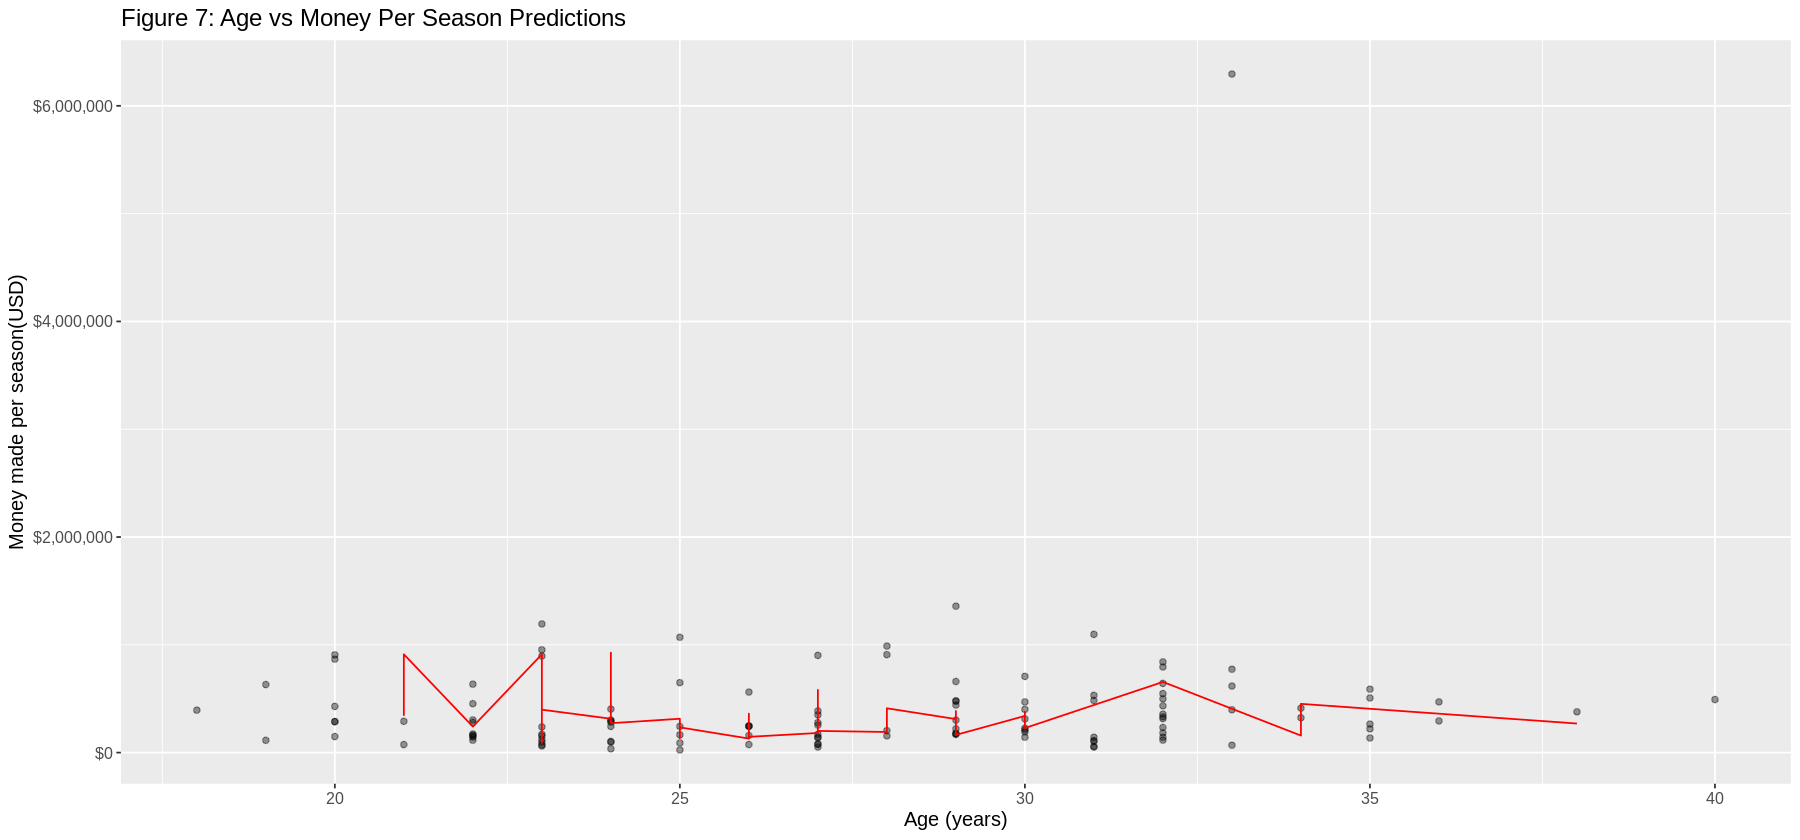

In [12]:
age_plot

Figure 8: For each observation in the training data the players current rank was plotted against their money made per season. The overlaid blue line is a plot of the corresponding predictions made by our model(predicting on the test set) for a player of any given rank. There are a few spikes but overall the model seems well fit to this predictor, it reflects the observed relationship that as current rank increases money per season tends to decrease. 

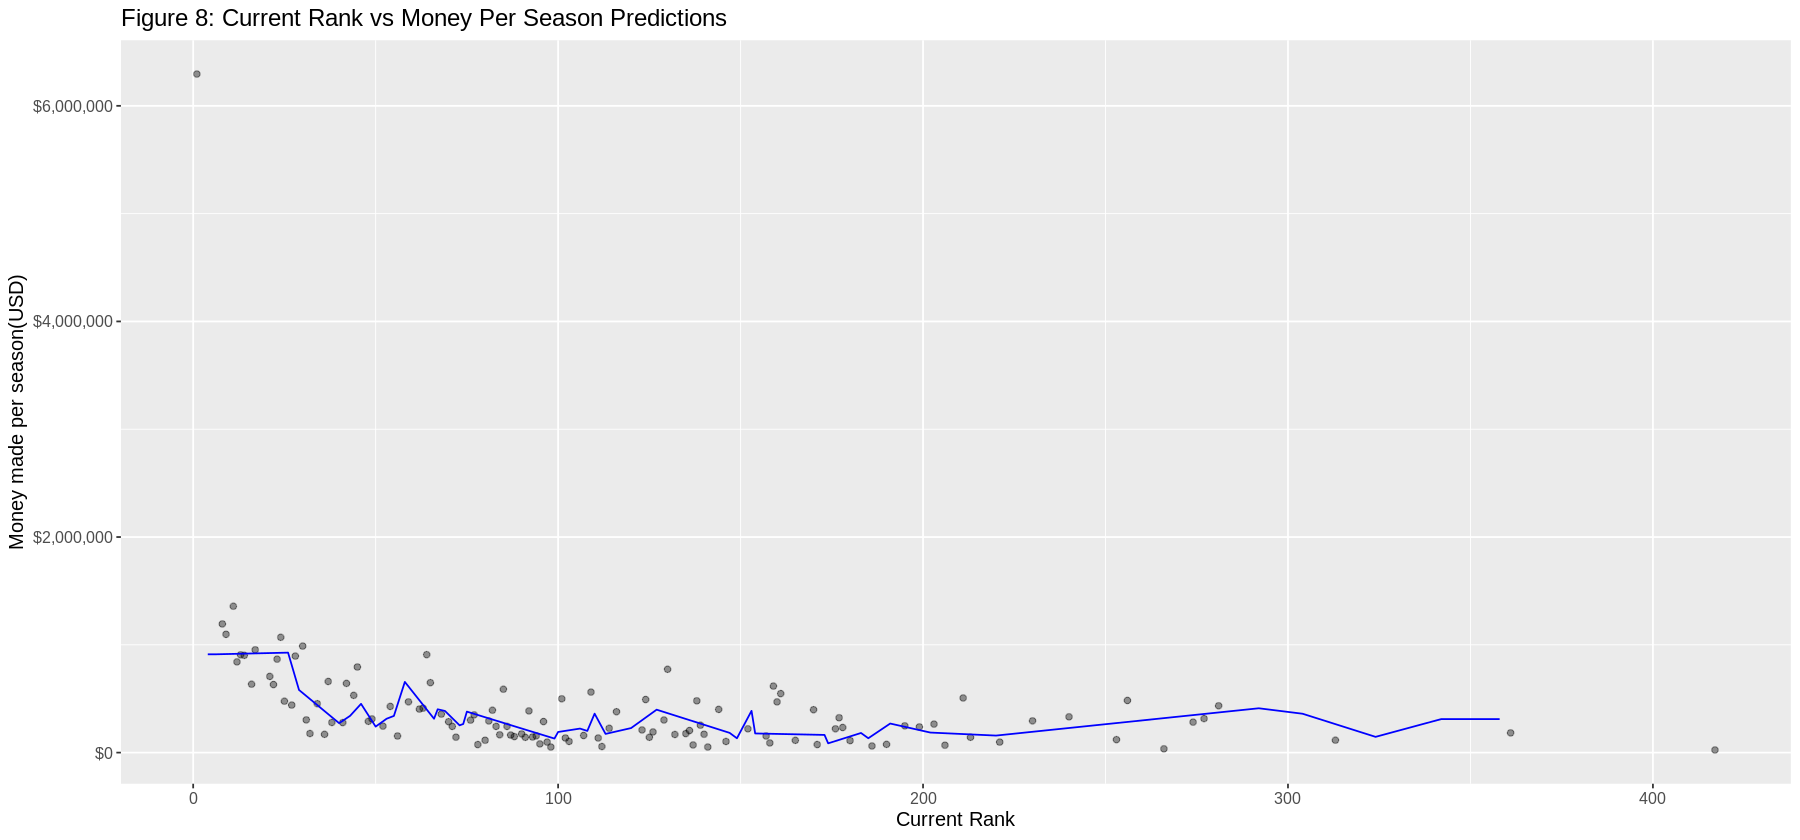

In [14]:
current_rank_plot

Figure 9: For each observation in the training data the players current elo rating was plotted against their money made per season. The green line is a plot of the predictions made by our model(predicting on the test set) for a player of any given elo rating. It seems to have a similar fit as current rank with a couple small peaks and valleys but generally echoing the trend within the data. That as elo rating increases so does the money made per season. 

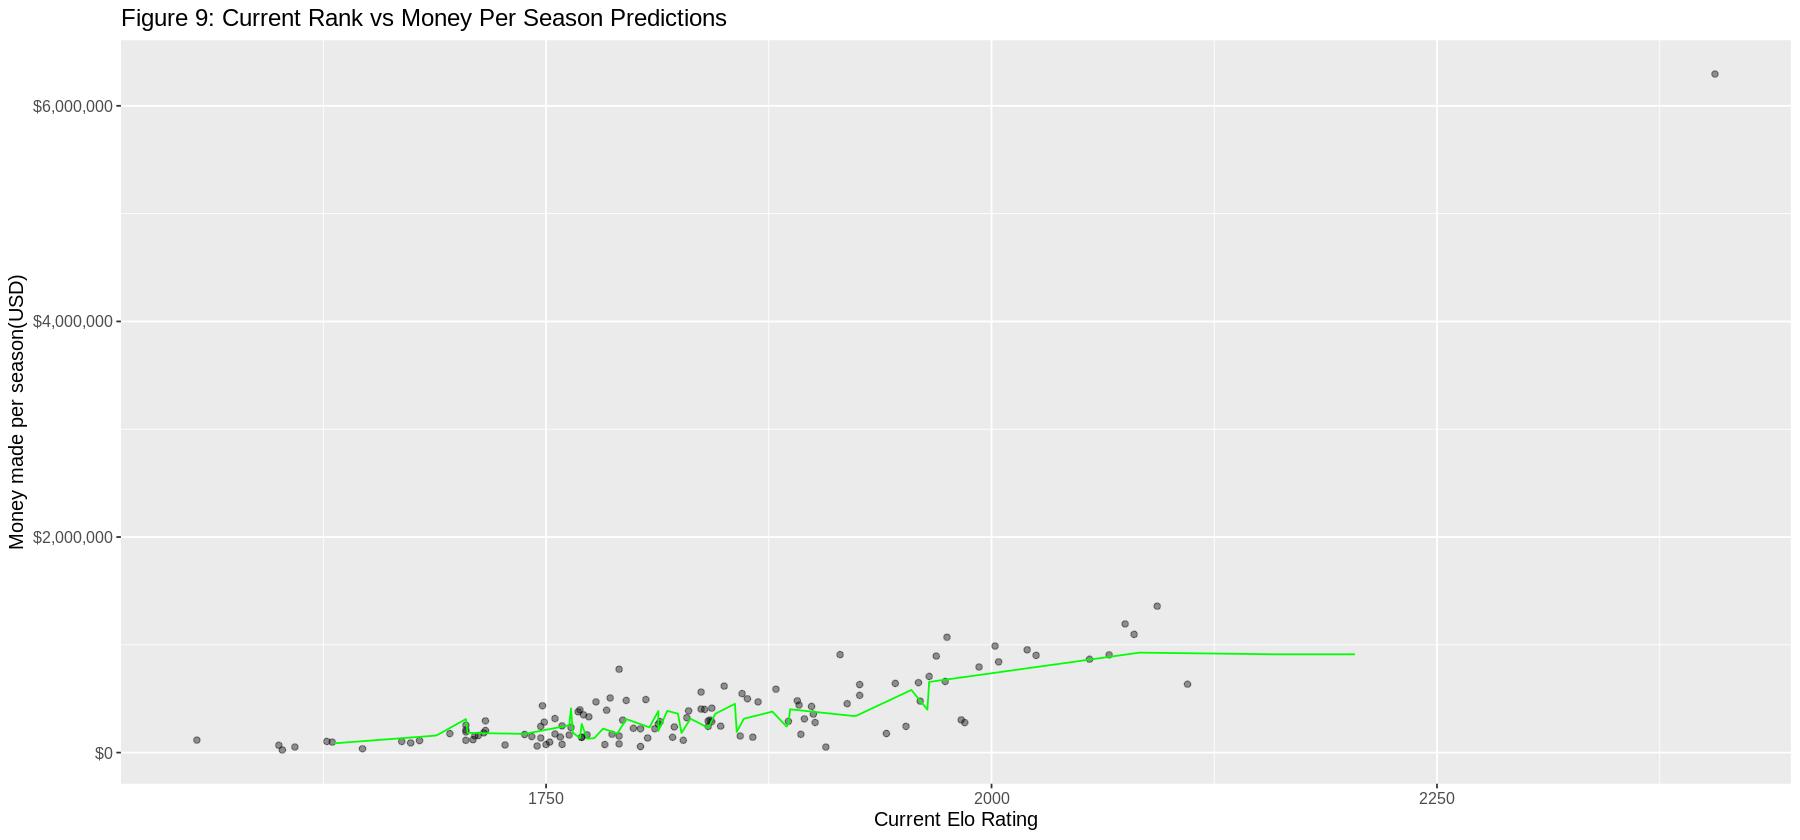

In [16]:
current_elo_plot

# Discussion

We found that our model can predict how much money a player is likely to make in the upcoming season with an error of 342,567.1. When compared to the RMSPE calculated from the training set predictions(337994.6) the difference is relatively small telling us that our model is able to adapt well to data which it has never seen before. However, the overall RMSE error is considerable large for our purposes as the majority of the players (with the exception of the outlier Rafael Nadal) have a Money.Per.Season of less than 2,000,000 so 342,567 would be a relativley large difference in their earnings. In future analysis we would like to explore the impact that other predictors could have on the model such as best overall rank and best overall rating to see if they could yield a model with a smaller RMSE value. One way to do this would be to use a forward selection algorithm to select the optimal predictor values.

The unexpected finding was the lack of correlation between age and money earned per season for each player. This implies that age alone may not be a reliable predictor of a player's earnings in professional tennis. On the other hand, we discovered a possible relationship between the independent variables of current rank and current Elo rating and the dependent variable of money earned every season. While this trend may give some insights, the high RMSE suggests that the model's forecasts are insufficient for exact earnings estimations.

These findings have a potential influence in a variety of ways. Understanding a player's future earnings can give useful insights into their marketability and investment possibilities for fans and sponsors. It may also assist players make financial decisions by estimating how much more earnings they need to gain outside of tournament prize money. Furthermore, these data might help to inform conversations regarding the financial elements of professional tennis, which could lead to changes in prize money distribution or sponsorship options. Overall, the findings in the analysis may have impacts on numerous stakeholders in the professional tennis business.

The findings in the analysis raise avenues for exploration of future research. We consider that exploring the impact of additional predictors could potentially improve the model's performance and reduce the RMSE. Therefore, One potential direction is how the inclusion of other factors such as best overall rank, best overall rating and their market value could affect the earnings predictions. In addition, considering the impact of external factors such as global events or changes in tournament structure on players' earnings could also provide valuable insights.

# Citations

1- Rankings: Pepperstone ATP Rankings FAQ: ATP Tour: Tennis: ATP tour: Tennis. ATP Tour. (n.d.).\
https://www.atptour.com/en/rankings/rankings-faq \
2- Jeff, A. (2023, April 14). An introduction to tennis elo. Heavy Topspin.\
http://www.tennisabstract.com/blog/2019/12/03/an-introduction-to-tennis-elo/ \
3- Encyclopedia.com. (n.d.). Aging and Athletic Performance. Encyclopedia.com. \
https://www.encyclopedia.com/sports/sports-fitness-recreation-and-leisure-magazines/aging-and-athletic-performance \
4- Ultimate Tennis Statistics. (n.d.). Player Stats for Top 500 Players. 